In [ ]:

import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import (
    RobertaTokenizer,
    RobertaForSequenceClassification,
    get_linear_schedule_with_warmup
)
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import os
import warnings
warnings.filterwarnings('ignore')

print("✓ All imports successful!")

✓ All imports successful!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
class Config:
    MODEL_NAME = 'roberta-base'
    NUM_LABELS = 2 
    MAX_LENGTH = 128
    TRAIN_BATCH_SIZE = 32
    EVAL_BATCH_SIZE = 32
    EPOCHS = 5
    LEARNING_RATE = 1.9755575225039977e-05 
    WARMUP_STEPS = 226
    WEIGHT_DECAY = 0.08717405559930652
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    NUM_WORKERS = 0 
    SEED = 42
    DATA_DIR = r'C:\Users\JASWA\Documents\Projects_AI\Twitter_sentiment_Analysis_NLP\data\processed'
    MODEL_SAVE_DIR = r'C:\Users\JASWA\Documents\Projects_AI\Twitter_sentiment_Analysis_NLP\models\checkpoints'
    RESULTS_DIR = r'C:\Users\JASWA\Documents\Projects_AI\Twitter_sentiment_Analysis_NLP\results'
config = Config()
torch.manual_seed(config.SEED)
np.random.seed(config.SEED)
os.makedirs(config.MODEL_SAVE_DIR, exist_ok=True)
os.makedirs(config.RESULTS_DIR, exist_ok=True)
os.makedirs('../results/plots', exist_ok=True)
print(f"Device: {config.DEVICE}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    print("GPU: Not available (using CPU - training will be slower)")
print(f"Model: {config.MODEL_NAME}")
print(f"Batch size: {config.TRAIN_BATCH_SIZE}")
print(f"Epochs: {config.EPOCHS}")
print(f"Learning rate: {config.LEARNING_RATE}")
print(f"Max length: {config.MAX_LENGTH}")

Device: cuda
GPU: Tesla T4
GPU Memory: 15.83 GB
Model: roberta-base
Batch size: 32
Epochs: 5
Learning rate: 1.9755575225039977e-05
Max length: 128


In [ ]:
class TweetSentimentDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=64):
        self.data = dataframe.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Get text and label
        text = str(self.data.loc[idx, 'text_clean'])
        label = int(self.data.loc[idx, 'sentiment'])

        # Tokenize
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

print("✓ Dataset class created!")

✓ Dataset class created!


In [ ]:
print("\nLoading datasets...")
train_df = pd.read_csv(f'{config.DATA_DIR}/train.csv')
val_df = pd.read_csv(f'{config.DATA_DIR}/val.csv')
test_df = pd.read_csv(f'{config.DATA_DIR}/test.csv')

print(f"Train samples: {len(train_df):,}")
print(f"Val samples: {len(val_df):,}")
print(f"Test samples: {len(test_df):,}")

# Check sentiment distribution
print(f"\nTrain sentiment distribution:")
print(train_df['sentiment'].value_counts().to_dict())


Loading datasets...
Train samples: 79,817
Val samples: 9,977
Test samples: 9,978

Train sentiment distribution:
{1: 39912, 0: 39905}


In [ ]:
tokenizer = RobertaTokenizer.from_pretrained(config.MODEL_NAME)
model = RobertaForSequenceClassification.from_pretrained(
    config.MODEL_NAME,
    num_labels=config.NUM_LABELS,
    output_attentions=False,
    output_hidden_states=False
)

model.to(config.DEVICE)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"✓ Model loaded successfully!")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ Model loaded successfully!
  Total parameters: 124,647,170
  Trainable parameters: 124,647,170


In [ ]:
train_dataset = TweetSentimentDataset(
    train_df,
    tokenizer,
    config.MAX_LENGTH
)
val_dataset = TweetSentimentDataset(
    val_df,
    tokenizer,
    config.MAX_LENGTH
)
test_dataset = TweetSentimentDataset(
    test_df,
    tokenizer,
    config.MAX_LENGTH
)

train_loader = DataLoader(
    train_dataset,
    batch_size=config.TRAIN_BATCH_SIZE,
    shuffle=True,
    num_workers=config.NUM_WORKERS
)

val_loader = DataLoader(
    val_dataset,
    batch_size=config.EVAL_BATCH_SIZE,
    shuffle=False,
    num_workers=config.NUM_WORKERS
)

test_loader = DataLoader(
    test_dataset,
    batch_size=config.EVAL_BATCH_SIZE,
    shuffle=False,
    num_workers=config.NUM_WORKERS
)

print(f"✓ Train batches: {len(train_loader)}")
print(f"✓ Val batches: {len(val_loader)}")
print(f"✓ Test batches: {len(test_loader)}")

✓ Train batches: 2495
✓ Val batches: 312
✓ Test batches: 312


In [ ]:
print("\nSetting up optimizer...")

optimizer = AdamW(
    model.parameters(),
    lr=config.LEARNING_RATE,
    weight_decay=config.WEIGHT_DECAY
)

total_steps = len(train_loader) * config.EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=config.WARMUP_STEPS,
    num_training_steps=total_steps
)

print(f"✓ Total training steps: {total_steps:,}")
print(f"✓ Warmup steps: {config.WARMUP_STEPS}")


Setting up optimizer...
✓ Total training steps: 12,475
✓ Warmup steps: 226


In [ ]:
def train_epoch(model, dataloader, optimizer, scheduler, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    progress_bar = tqdm(dataloader, desc='Training')

    for batch in progress_bar:
        # Move to device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        # Forward pass
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        loss = outputs.loss
        logits = outputs.logits
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        # Track metrics
        total_loss += loss.item()
        predictions = torch.argmax(logits, dim=1)
        correct += (predictions == labels).sum().item()
        total += labels.size(0)
        # Update progress bar
        progress_bar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{correct/total:.4f}'
        })
    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total
    return avg_loss, accuracy

In [ ]:
def evaluate(model, dataloader, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_predictions = []
    all_labels = []
    progress_bar = tqdm(dataloader, desc='Evaluating')
    with torch.no_grad():
        for batch in progress_bar:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            loss = outputs.loss
            logits = outputs.logits
            total_loss += loss.item()
            predictions = torch.argmax(logits, dim=1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total
    return avg_loss, accuracy, all_predictions, all_labels
print("✓ Training functions defined!")

✓ Training functions defined!


In [ ]:
best_val_accuracy = 0
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

for epoch in range(config.EPOCHS):
    print(f"\nEpoch {epoch + 1}/{config.EPOCHS}")
    print("-" * 60)

    # Train
    train_loss, train_acc = train_epoch(
        model,
        train_loader,
        optimizer,
        scheduler,
        config.DEVICE
    )
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")

    val_loss, val_acc, _, _ = evaluate(
        model,
        val_loader,
        config.DEVICE
    )
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    # Save best model
    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        torch.save(
            model.state_dict(),
            f'{config.MODEL_SAVE_DIR}/best_roberta_final.pt'
        )
        print(f"✓ Best model saved! (Val Acc: {val_acc:.4f})")

print(f"Best validation accuracy: {best_val_accuracy:.4f}\n")


Epoch 1/5
------------------------------------------------------------


Training:   0%|          | 0/2495 [00:00<?, ?it/s]

Train Loss: 0.4017 | Train Acc: 0.8167


Evaluating:   0%|          | 0/312 [00:00<?, ?it/s]

Val Loss: 0.3385 | Val Acc: 0.8557
✓ Best model saved! (Val Acc: 0.8557)

Epoch 2/5
------------------------------------------------------------


Training:   0%|          | 0/2495 [00:00<?, ?it/s]

Train Loss: 0.3043 | Train Acc: 0.8725


Evaluating:   0%|          | 0/312 [00:00<?, ?it/s]

Val Loss: 0.3514 | Val Acc: 0.8586
✓ Best model saved! (Val Acc: 0.8586)

Epoch 3/5
------------------------------------------------------------


Training:   0%|          | 0/2495 [00:00<?, ?it/s]

Train Loss: 0.2395 | Train Acc: 0.9046


Evaluating:   0%|          | 0/312 [00:00<?, ?it/s]

Val Loss: 0.3486 | Val Acc: 0.8659
✓ Best model saved! (Val Acc: 0.8659)

Epoch 4/5
------------------------------------------------------------


Training:   0%|          | 0/2495 [00:00<?, ?it/s]

Train Loss: 0.1823 | Train Acc: 0.9309


Evaluating:   0%|          | 0/312 [00:00<?, ?it/s]

Val Loss: 0.4217 | Val Acc: 0.8600

Epoch 5/5
------------------------------------------------------------


Training:   0%|          | 0/2495 [00:00<?, ?it/s]

Train Loss: 0.1424 | Train Acc: 0.9492


Evaluating:   0%|          | 0/312 [00:00<?, ?it/s]

Val Loss: 0.4688 | Val Acc: 0.8584
Best validation accuracy: 0.8659



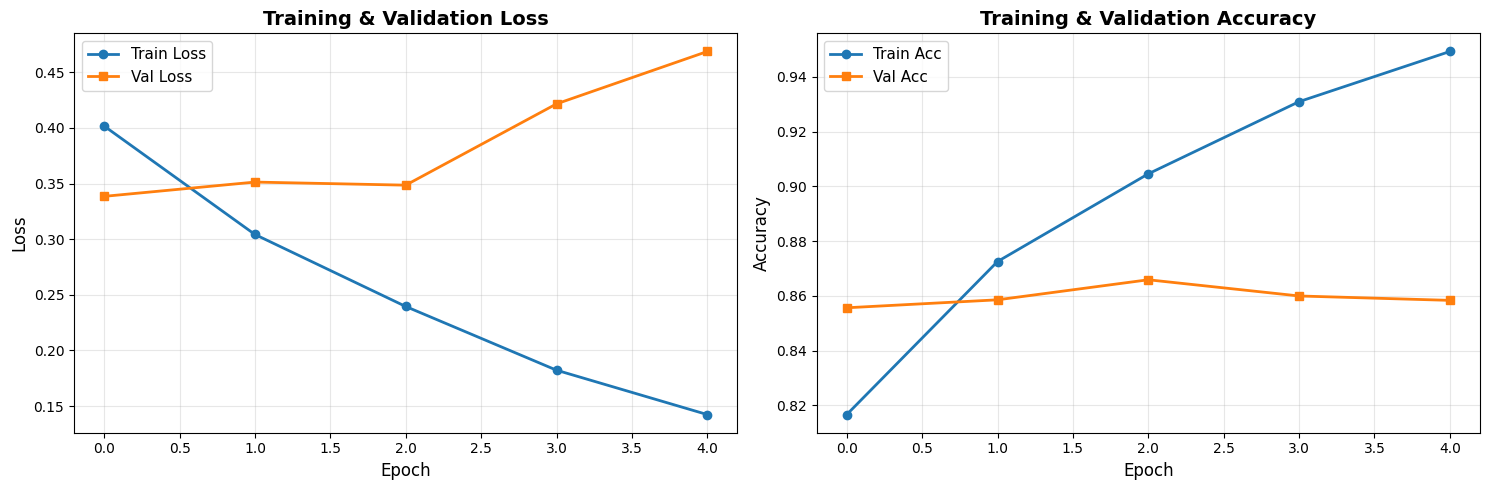

✓ Training plots saved!
✓ Training history saved!


In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(history['train_loss'], label='Train Loss', marker='o', linewidth=2)
ax1.plot(history['val_loss'], label='Val Loss', marker='s', linewidth=2)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Training & Validation Loss', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)
ax2.plot(history['train_acc'], label='Train Acc', marker='o', linewidth=2)
ax2.plot(history['val_acc'], label='Val Acc', marker='s', linewidth=2)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy', fontsize=12)
ax2.set_title('Training & Validation Accuracy', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{config.RESULTS_DIR}/plots/training_history_roberta_final.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Training plots saved!")

# Save history to CSV
history_df = pd.DataFrame(history)
history_df.to_csv(f'{config.RESULTS_DIR}/training_history_roberta_final.csv', index=False)
print("✓ Training history saved!")

Evaluating:   0%|          | 0/312 [00:00<?, ?it/s]

Test Loss: 0.3557
Test Accuracy: 0.8553

Classification Report:
------------------------------------------------------------
              precision    recall  f1-score   support

    Negative     0.8395    0.8785    0.8585      4988
    Positive     0.8726    0.8321    0.8519      4990

    accuracy                         0.8553      9978
   macro avg     0.8560    0.8553    0.8552      9978
weighted avg     0.8561    0.8553    0.8552      9978



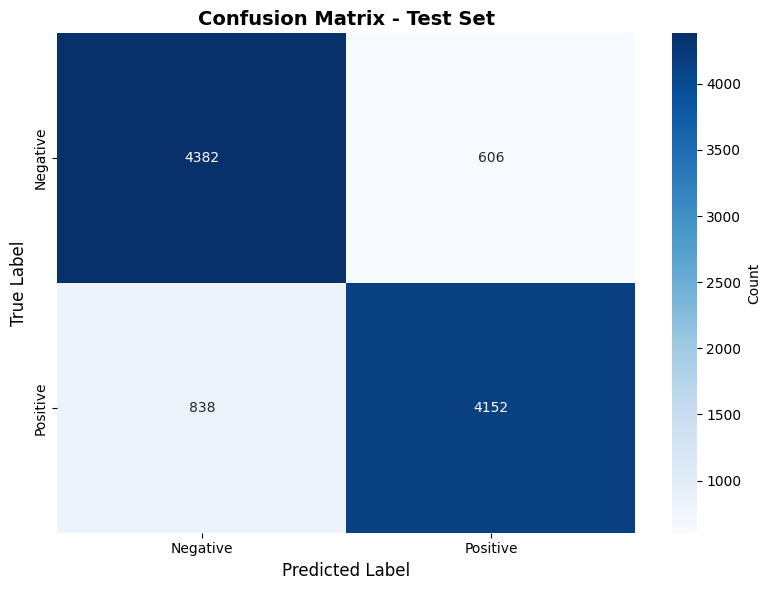

✓ Confusion matrix saved!


In [ ]:

model.load_state_dict(torch.load(f'{config.MODEL_SAVE_DIR}/best_roberta.pt'))
model.to(config.DEVICE)

# Evaluate
test_loss, test_acc, test_preds, test_labels = evaluate(
    model,
    test_loader,
    config.DEVICE
)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}\n")

# Classification report
print("Classification Report:")
print("-" * 60)
print(classification_report(
    test_labels,
    test_preds,
    target_names=['Negative', 'Positive'],
    digits=4
))

# Confusion matrix
cm = confusion_matrix(test_labels, test_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Negative', 'Positive'],
    yticklabels=['Negative', 'Positive'],
    cbar_kws={'label': 'Count'}
)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.title('Confusion Matrix - Test Set', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(f'{config.RESULTS_DIR}/plots/confusion_matrix_roberta_final.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Confusion matrix saved!")

In [ ]:

# TEST ON CUSTOM TWEETS
def predict_sentiment(text, model, tokenizer, device, max_length=64):
    """Predict sentiment for a single tweet"""
    model.eval()
    encoding = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    
    with torch.no_grad():
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        
        logits = outputs.logits
        probs = torch.softmax(logits, dim=1)
        prediction = torch.argmax(probs, dim=1).item()
        confidence = probs[0][prediction].item()
    
    sentiment = 'Positive' if prediction == 1 else 'Negative'
    return sentiment, confidence

custom_tweets = [
    "I absolutely love this product! Best purchase ever! 😍",
    "This is the worst thing I've ever bought. Terrible! 😠",
    "Not sure how I feel about this...",
    "It's okay, nothing special",
    "OMG this is amazing!!! Highly recommend!!!",
    "Terrible customer service. Very disappointed.",
    "Pretty good, would buy again",
    "Meh, it's alright I guess"
]

print("Making predictions...\n")
for tweet in custom_tweets:
    sentiment, confidence = predict_sentiment(
        tweet,
        model,
        tokenizer,
        config.DEVICE,
        config.MAX_LENGTH
    )
    print(f"Tweet: {tweet}")
    print(f"→ Prediction: {sentiment} (Confidence: {confidence:.2%})\n")
print(f"\nKey Results:")
print(f"  • Best Val Accuracy: {best_val_accuracy:.4f}")
print(f"  • Test Accuracy: {test_acc:.4f}")


Making predictions...

Tweet: I absolutely love this product! Best purchase ever! 😍
→ Prediction: Positive (Confidence: 99.63%)

Tweet: This is the worst thing I've ever bought. Terrible! 😠
→ Prediction: Negative (Confidence: 95.90%)

Tweet: Not sure how I feel about this...
→ Prediction: Negative (Confidence: 98.47%)

Tweet: It's okay, nothing special
→ Prediction: Positive (Confidence: 97.23%)

Tweet: OMG this is amazing!!! Highly recommend!!!
→ Prediction: Positive (Confidence: 99.58%)

Tweet: Terrible customer service. Very disappointed.
→ Prediction: Negative (Confidence: 99.75%)

Tweet: Pretty good, would buy again
→ Prediction: Positive (Confidence: 99.38%)

Tweet: Meh, it's alright I guess
→ Prediction: Positive (Confidence: 73.68%)


Key Results:
  • Best Val Accuracy: 0.8659
  • Test Accuracy: 0.8553
